In [1]:
import os
import cv2
import random
import time 

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.models import *


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-02-25 12:11:35.905673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 12:11:35.905793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 12:11:36.022811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
len(os.listdir('/kaggle/input/brain-tumor-mri-images-44c/'))

44

In [5]:
data_path= "/kaggle/input/brain-tumor-mri-images-44c"

In [6]:
df = pd.DataFrame(columns=['path','label'])

In [7]:
folder = os.listdir(data_path)
def create_df(df,folder,data_path):
    for fold in folder:
        class_path = os.path.join(data_path,fold)
        class_folder = os.listdir(class_path)
        for img in class_folder:
            img_path = os.path.join(class_path,img)
            df = df._append({'path':os.path.join(class_path,img) , 'label' : fold},ignore_index=True)
    return df

In [8]:
df = create_df(df,folder,data_path)
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2


In [9]:
#df.to_pickle('initial_dataset.pkl')


In [10]:
#df = pd.read_pickle('/kaggle/working/initial_dataset.pkl')
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2


In [11]:
df.shape

(4479, 2)

In [12]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
sorted_label = label_counts.index

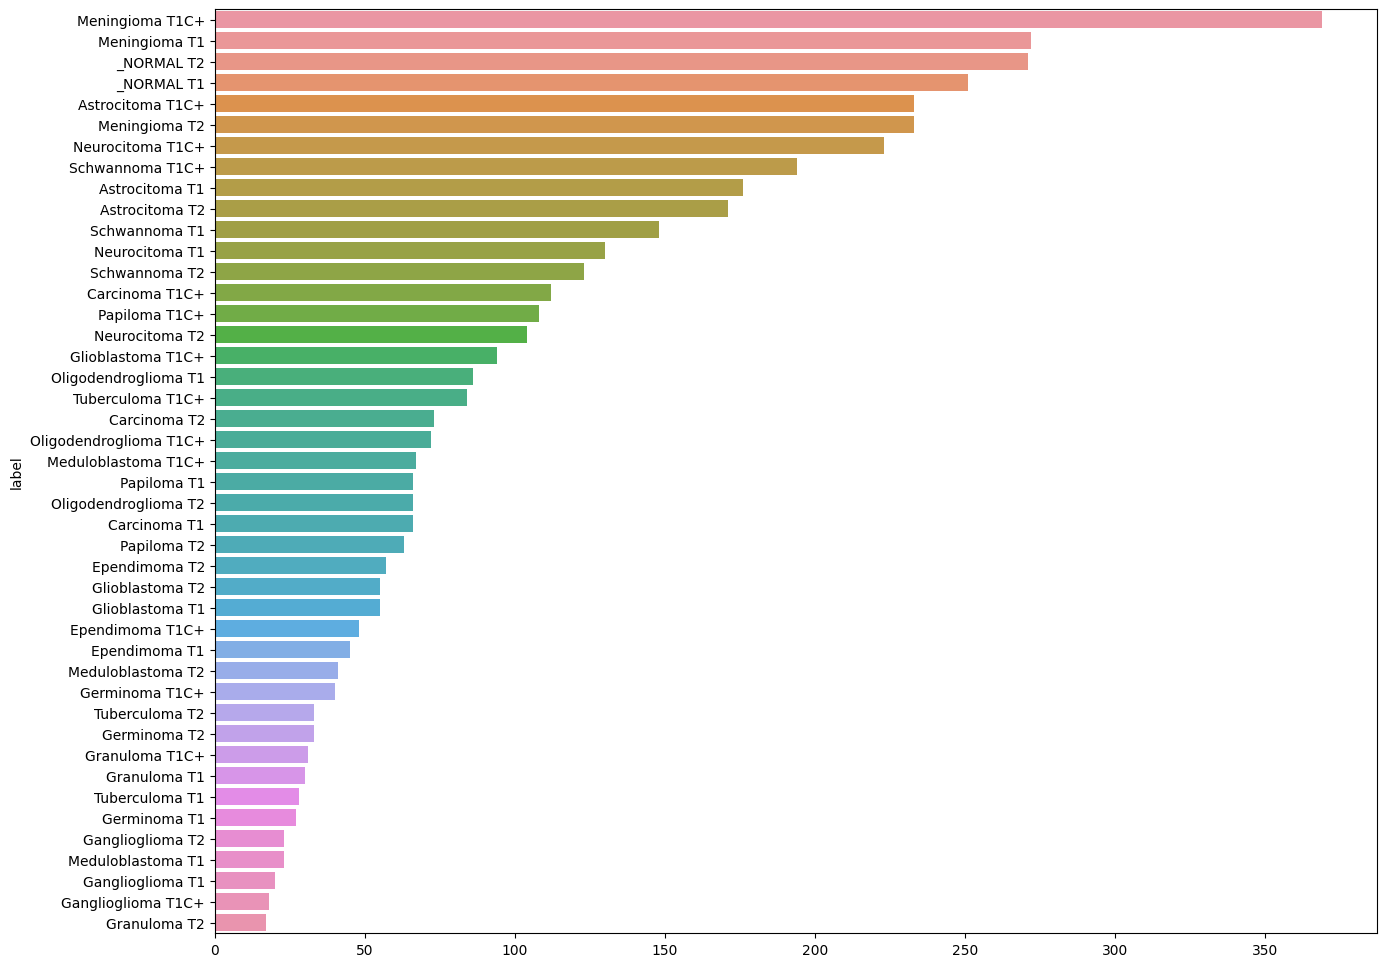

In [13]:
plt.figure(figsize=(15,12))
sns.barplot(x=label_counts.values, y=sorted_label)
plt.show()

In [14]:
augmented_image_path = '/kaggle/working/augmented_images/'

In [15]:
os.makedirs(augmented_image_path, exist_ok=True)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

In [17]:
target_samples = 400

In [18]:
augmented_df = pd.DataFrame(columns=['path', 'label'])

In [19]:
def balancing_class_aug(df,augmented_df,target_samples,datagen,data_path,augmented_image_path):
    for label in df['label'].unique():
        class_subset = df[df['label'] == label]  # Get all images in the class
        n_samples_needed = target_samples - class_subset.shape[0]
        if n_samples_needed > 0:
            generator = datagen.flow_from_dataframe(
                class_subset,
                directory=data_path,
                x_col='path',
                y_col='label',
                class_mode='categorical',  
                batch_size=1,
                save_to_dir=augmented_image_path,
                save_prefix='aug_',
                save_format='png'
            )
            
        for i in range(n_samples_needed):
            images, labels = next(generator)
            new_image_path = os.path.join(augmented_image_path, f'aug_{i}.png')
            augmented_df = augmented_df._append({'path': new_image_path, 'label': label},ignore_index=True)
    return augmented_df

    

In [20]:
augmented_df = balancing_class_aug(df,augmented_df,target_samples,datagen,data_path,augmented_image_path)


Found 63 validated image filenames belonging to 1 classes.
Found 84 validated image filenames belonging to 1 classes.
Found 30 validated image filenames belonging to 1 classes.
Found 73 validated image filenames belonging to 1 classes.
Found 251 validated image filenames belonging to 1 classes.
Found 23 validated image filenames belonging to 1 classes.
Found 130 validated image filenames belonging to 1 classes.
Found 194 validated image filenames belonging to 1 classes.
Found 66 validated image filenames belonging to 1 classes.
Found 40 validated image filenames belonging to 1 classes.
Found 41 validated image filenames belonging to 1 classes.
Found 233 validated image filenames belonging to 1 classes.
Found 104 validated image filenames belonging to 1 classes.
Found 171 validated image filenames belonging to 1 classes.
Found 72 validated image filenames belonging to 1 classes.
Found 28 validated image filenames belonging to 1 classes.
Found 271 validated image filenames belonging to 1

In [21]:
#augmented_df.to_pickle('augmented_balanced_dataset.pkl')
#augmented_df = pd.read_pickle('/kaggle/working/augmented_balanced_dataset.pkl')
augmented_df.head()

,path,label
0,/kaggle/working/augmented_images/aug_0.png,Papiloma T2
1,/kaggle/working/augmented_images/aug_1.png,Papiloma T2
2,/kaggle/working/augmented_images/aug_2.png,Papiloma T2
3,/kaggle/working/augmented_images/aug_3.png,Papiloma T2
4,/kaggle/working/augmented_images/aug_4.png,Papiloma T2


In [22]:
label_counts_aug = augmented_df['label'].value_counts().sort_values(ascending=True)
sorted_label_aug = label_counts_aug.index

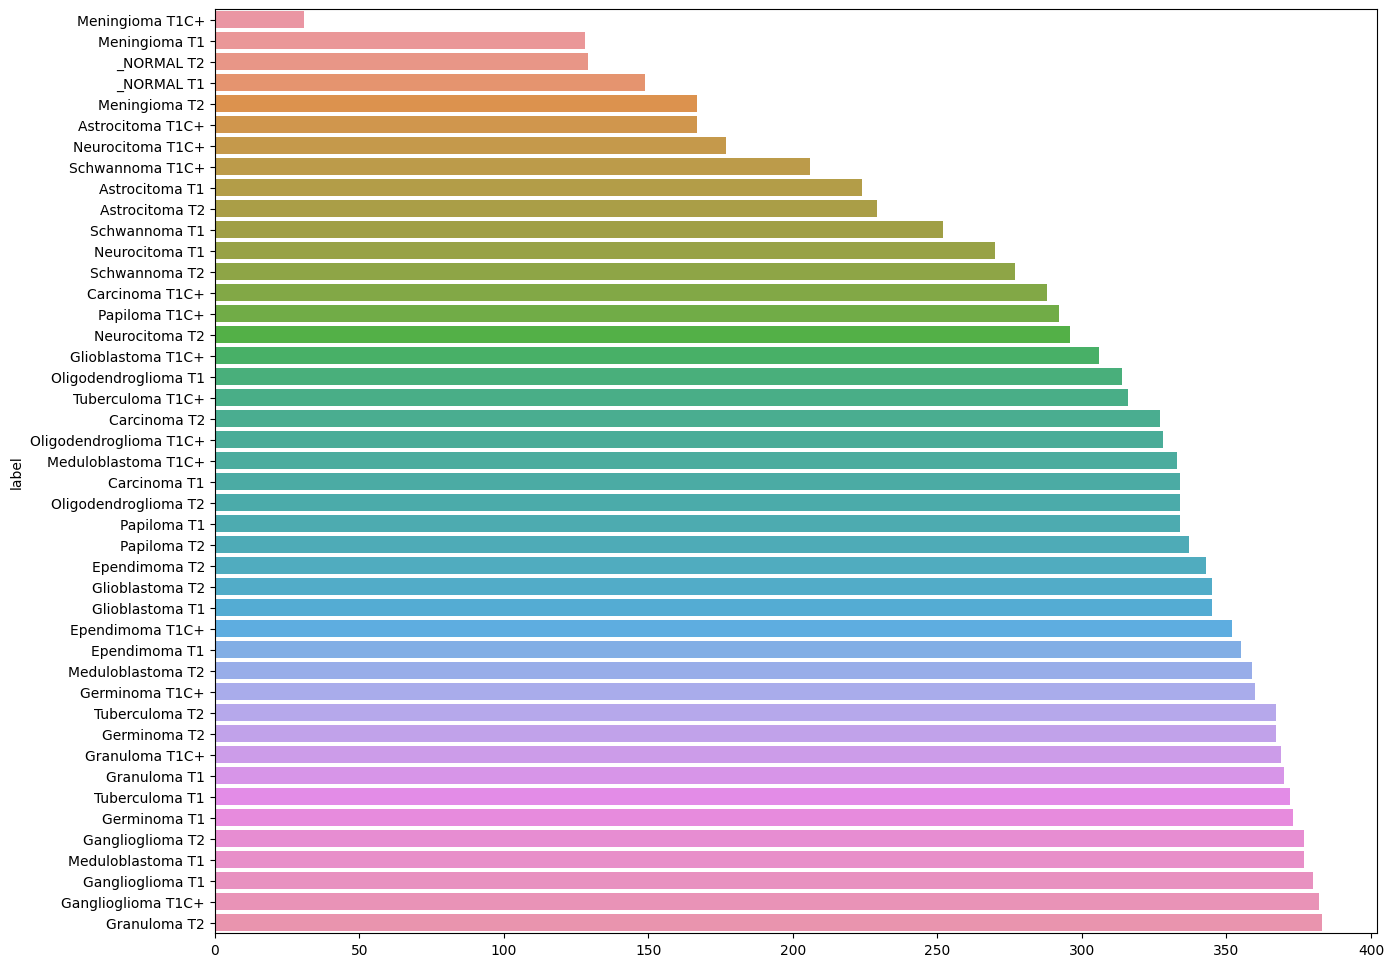

In [23]:
plt.figure(figsize=(15,12))
sns.barplot(x=label_counts_aug.values, y=sorted_label_aug)
plt.show()

In [24]:
full_df = pd.concat([df, augmented_df], ignore_index=True)

In [25]:
full_df.shape

(17600, 2)

In [26]:
label_counts_full = full_df['label'].value_counts().sort_values(ascending=False)
sorted_label_full = label_counts_full.index

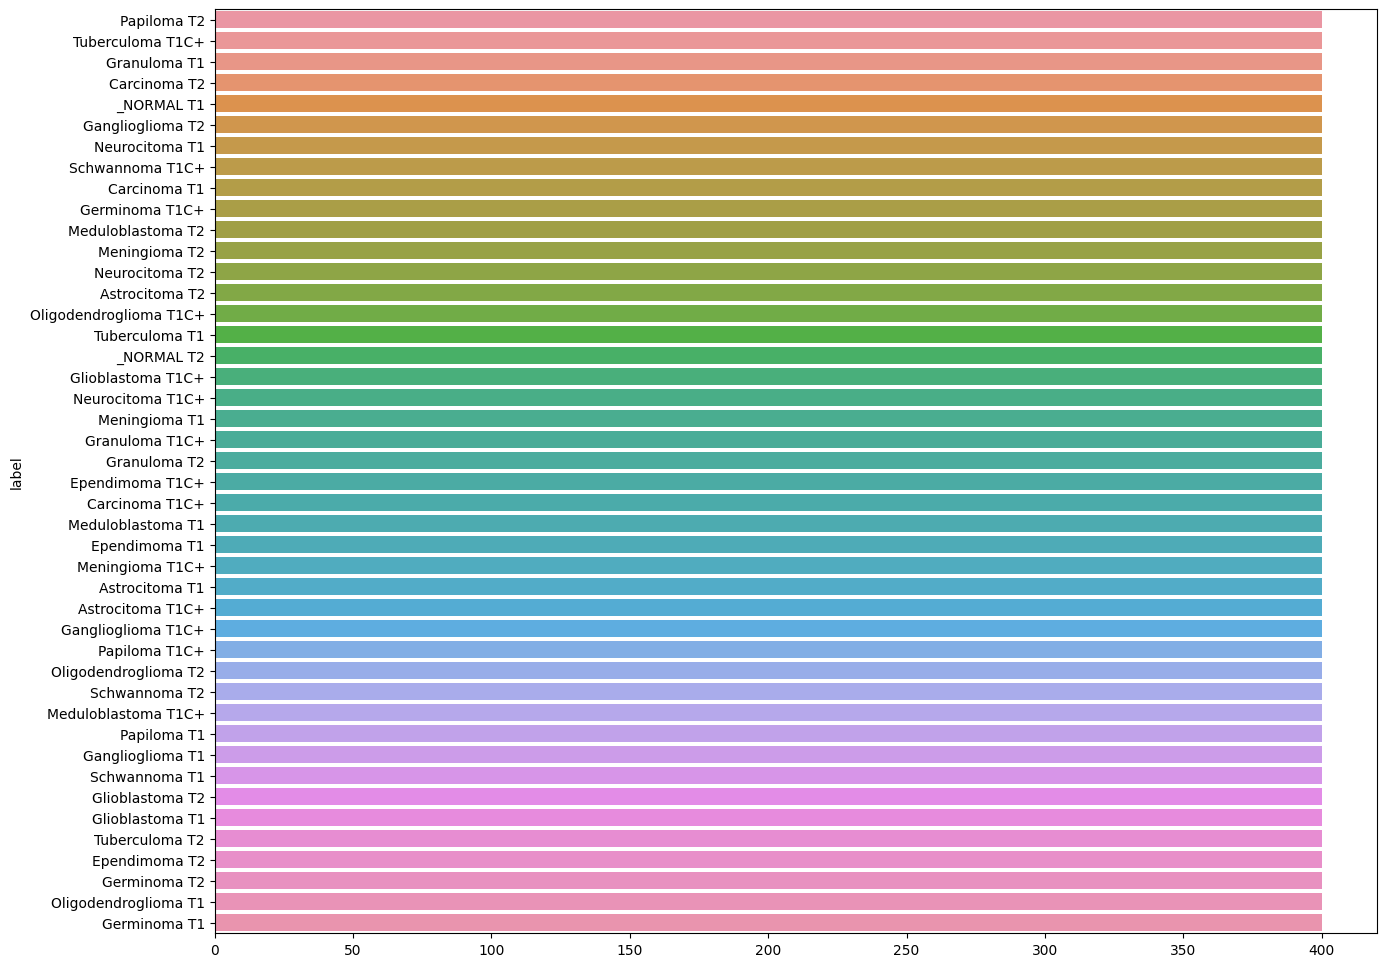

In [27]:
plt.figure(figsize=(15,12))
sns.barplot(x=label_counts_full.values, y=sorted_label_full)
plt.show()

In [28]:
df_shuffle = full_df.sample(frac=1).reset_index(drop=True)
df_shuffle.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T2
1,/kaggle/working/augmented_images/aug_23.png,Tuberculoma T1C+
2,/kaggle/working/augmented_images/aug_356.png,Ganglioglioma T1C+
3,/kaggle/working/augmented_images/aug_93.png,Neurocitoma T1C+
4,/kaggle/working/augmented_images/aug_292.png,Papiloma T2


In [29]:
train_df, tv_df = train_test_split(df_shuffle, test_size=0.3, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(tv_df, test_size=0.5, shuffle=True, random_state=123)

In [30]:
train_df

,path,label
8224,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma T1C+
12008,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
9700,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL T1
2144,/kaggle/working/augmented_images/aug_269.png,Tuberculoma T1C+
17515,/kaggle/working/augmented_images/aug_138.png,Oligodendroglioma T2
...,...,...
96,/kaggle/working/augmented_images/aug_185.png,Oligodendroglioma T1C+
13435,/kaggle/working/augmented_images/aug_305.png,Carcinoma T2
7763,/kaggle/working/augmented_images/aug_142.png,Astrocitoma T2
15377,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma T1


In [31]:
test_df

,path,label
6815,/kaggle/working/augmented_images/aug_232.png,Glioblastoma T1
5163,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma T2
7343,/kaggle/working/augmented_images/aug_50.png,Granuloma T1C+
10677,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
6840,/kaggle/working/augmented_images/aug_225.png,Glioblastoma T1
...,...,...
1296,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,Oligodendroglioma T2
16562,/kaggle/working/augmented_images/aug_143.png,Meduloblastoma T1
5033,/kaggle/working/augmented_images/aug_44.png,Astrocitoma T1
14658,/kaggle/working/augmented_images/aug_34.png,Carcinoma T1C+


In [32]:
valid_df

,path,label
2590,/kaggle/working/augmented_images/aug_196.png,Schwannoma T2
5054,/kaggle/working/augmented_images/aug_84.png,Meningioma T1
2416,/kaggle/working/augmented_images/aug_267.png,Tuberculoma T1C+
15953,/kaggle/working/augmented_images/aug_199.png,Ependimoma T2
973,/kaggle/working/augmented_images/aug_127.png,Ependimoma T1C+
...,...,...
14102,/kaggle/input/brain-tumor-mri-images-44c/Carci...,Carcinoma T1C+
1409,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL T1
8701,/kaggle/working/augmented_images/aug_166.png,Germinoma T1
8280,/kaggle/input/brain-tumor-mri-images-44c/Granu...,Granuloma T1C+


In [33]:
print(f"We have {len(train_df)} images in the training dataset\nWe have {len(valid_df)} images in the validating dataset\nWe have {len(test_df)} images in the testing dataset")

We have 12320 images in the training dataset
We have 2640 images in the validating dataset
We have 2640 images in the testing dataset
